In [81]:
import numpy as np
import sympy as sp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import fsolve,root

x = sp.symbols('x')

M_p = 1
v = 0

# Definir el valor de xi (debería ser >>1)

xi=10000

# Definir la función phi(h)
def phi_of_h(x,xi):
    return (sp.sqrt(1 + 6*xi)*sp.asinh(sp.sqrt(1 + 6*xi)*sp.sqrt(xi)*x) -
            sp.sqrt(6*xi)*sp.asinh(sp.sqrt(xi)*sp.sqrt(xi)*x/sp.sqrt(1 + xi*x**2)))/sp.sqrt(xi)

def potencial(x,lambda_0,xi):
    return (x**2-v**2)**2/4/(1+xi*x**2)**2*lambda_0

def evol_h(h,N,lambda_0,xi):
    
    derivada_1 = sp.diff(potencial(x,lambda_0,xi),x)
    dphi_dh = sp.diff(phi_of_h(x,xi),x)
    
    V=potencial(h[0],lambda_0,xi)
    Vd=derivada_1.evalf(subs={x: h[0]})
    dphidh=dphi_dh.evalf(subs={x: h[0]})
    
    return V*dphidh**2/Vd

def fit_h_0_try(h_0,lambda_0,xi):
    
    if h_0<0:
        h_0=-h_0
    
    derivada_1 = sp.diff(potencial(x,lambda_0,xi),x)
    dphi_dh = sp.diff(phi_of_h(x,xi),x)
    
    V_0=potencial(h_0[0],lambda_0,xi)
    Vd_0=derivada_1.evalf(subs={x: h_0[0]})
    dphidh_0=dphi_dh.evalf(subs={x: h_0[0]})
    #print("Nueva iteración para h_0: ",1-((M_p*Vd_0/V_0/dphidh_0)**2)/2, h_0[0])
    
    return 1-((Vd_0/V_0/dphidh_0)**2)/2

def correct_h_0_try(lambda_0,xi):
    
    x_0=0.15 #parámetro inicial de iteración
    
    h_0=fsolve(fit_h_0_try,x_0,args=(lambda_0,xi))
    
    return np.abs(h_0[0])

def fit_h_60_try(h_60,h_0,lambda_0,xi):
    
    if h_60<0:
        h_60=-h_60
        
    #print("Nueva iteración para h_60: ",60-3/4*((xi+1/6)*(h_60[0]**2-h_0**2)-sp.log((1+xi*h_60[0]**2)/(1+xi*h_0**2))), h_60[0])
    
    return 60-3/4*((xi+1/6)*(h_60[0]**2-h_0**2)-sp.log((1+xi*h_60[0]**2)/(1+xi*h_0**2)))

def correct_h_60_try(h_0,lambda_0,xi):
    
    x_0=1.5 #parámetro inicial de iteración
    
    h_60=fsolve(fit_h_60_try,x_0,args=(h_0,lambda_0,xi))
    
    return np.abs(h_60[0])

def fit(x_fit,xi):
    
    lambda_0=x_fit[0]
    
    h_0=correct_h_0_try(lambda_0,xi)
        
    if lambda_0<0:
        lambda_0=-lambda_0
    
    #Expresión de las derivadas del potencial pero sin evaluar en phi todavía
    
    derivada_1 = sp.diff(potencial(x,lambda_0,xi),x)
    derivada_2 = sp.diff(derivada_1,x)
    dphi_dh = sp.diff(phi_of_h(x,xi),x)
    dphi_dh_2 = sp.diff(dphi_dh,x)
    
    N=np.linspace(0,60,500)
    
    #Calculo phi(N)
    
    #h_N=odeint(evol_h,h_0,N,args=(lambda_0,xi))
    
    #h_f=h_N[-1]
    #h_60=h_f[0]
    
    h_60=correct_h_60_try(h_0,lambda_0,xi)
    
    #Obtengo los parámetros del sistema (potencial, eps y eta) para phi(N=0) (_0) y phi(N=60) (_60)
    
    V_0=potencial(h_0,lambda_0,xi)
    Vd_0=derivada_1.evalf(subs={x: h_0})
    Vdd_0=derivada_2.evalf(subs={x: h_0})
    dphidh_0 = dphi_dh.evalf(subs={x: h_0})
    dphidh2_0 = dphi_dh_2.evalf(subs={x: h_0})
    
    V_60=potencial(h_60,lambda_0,xi)
    Vd_60=derivada_1.evalf(subs={x: h_60})
    Vdd_60=derivada_2.evalf(subs={x: h_60})
    dphidh_60 = dphi_dh.evalf(subs={x: h_60})
    dphidh2_60 = dphi_dh_2.evalf(subs={x: h_60})
    
    eps_v_0=((M_p*Vd_0/V_0/dphidh_0)**2)/2
    eta_v_0=(Vdd_0*dphidh_0-Vd_0*dphidh2_0)/V_0/dphidh_0**3
    eps_0=eps_v_0
    eta_0=4*eps_v_0-2*eta_v_0
    
    eps_v_60=((M_p*Vd_60/V_60/dphidh_60)**2)/2
    eta_v_60=(Vdd_60*dphidh_60-Vd_60*dphidh2_60)/V_60/dphidh_60**3
    eps_60=eps_v_60
    eta_60=4*eps_v_60-2*eta_v_60
    
    #Para ir viendo como va la iteración
    #print('Epsilon:',eps_0,', n_s:',1-eta_60-2*eps_60,', P_r:',sp.log(V_60/24/sp.pi**2/eps_60/M_p**4*10**10).evalf(),', r:',16*eps_60)
    #print("h_0: ",h_0,", xi: ",xi,", lambda_0: ",lambda_0)
    
    #Tiene esta estructura porque fsolve resuelve numéricamente la ecuación f(x)=0
    #En orden: fijación del power spectrum (en N=60)
    return 3.094-sp.log(V_60/24/sp.pi**2/eps_60/M_p**4*10**10)


def all_parameters(h_0,lambda_0,xi):
    
    if lambda_0<0:
        lambda_0=-lambda_0
    
    #Expresión de las derivadas del potencial pero sin evaluar en phi todavía
    
    derivada_1 = sp.diff(potencial(x,lambda_0,xi),x)
    derivada_2 = sp.diff(derivada_1,x)
    dphi_dh = sp.diff(phi_of_h(x,xi),x)
    dphi_dh_2 = sp.diff(dphi_dh,x)
    
    N=np.linspace(0,60,500)
    
    #Calculo phi(N)
    
    #h_N=odeint(evol_h,h_0,N,args=(lambda_0,xi))
    
    #h_f=h_N[-1]
    #h_60=h_f[0]
    
    h_60=correct_h_60_try(h_0,lambda_0,xi)
    
    #Obtengo los parámetros del sistema (potencial, eps y eta) para phi(N=0) (_0) y phi(N=60) (_60)
    
    V_0=potencial(h_0,lambda_0,xi)
    Vd_0=derivada_1.evalf(subs={x: h_0})
    Vdd_0=derivada_2.evalf(subs={x: h_0})
    dphidh_0 = dphi_dh.evalf(subs={x: h_0})
    dphidh2_0 = dphi_dh_2.evalf(subs={x: h_0})
    
    V_60=potencial(h_60,lambda_0,xi)
    Vd_60=derivada_1.evalf(subs={x: h_60})
    Vdd_60=derivada_2.evalf(subs={x: h_60})
    dphidh_60 = dphi_dh.evalf(subs={x: h_60})
    dphidh2_60 = dphi_dh_2.evalf(subs={x: h_60})
    
    eps_v_0=((M_p*Vd_0/V_0/dphidh_0)**2)/2
    eta_v_0=(Vdd_0*dphidh_0-Vd_0*dphidh2_0)/V_0/dphidh_0**3
    eps_0=eps_v_0
    eta_0=4*eps_v_0-2*eta_v_0
    
    eps_v_60=((M_p*Vd_60/V_60/dphidh_60)**2)/2
    eta_v_60=(Vdd_60*dphidh_60-Vd_60*dphidh2_60)/V_60/dphidh_60**3
    eps_60=eps_v_60
    eta_60=4*eps_v_60-2*eta_v_60
    
    P_r=sp.log(V_60/24/sp.pi**2/eps_60/M_p**4*10**10)
    n_s=1-eta_60-2*eps_60
    r=16*eps_60
    
    print("El valor de n_s es ",n_s)
    print("El valor de r es ", r)
    print("La normalización de P_r es", P_r.evalf())
    print("El valor de eps(0) es ", eps_0)
    
    return [eps_0,n_s,r,P_r]

In [83]:
xi=0.001
lambda_0_0=1e-5

x_0=lambda_0_0

solutions = root(fit, x_0, args=(xi,))

lambda_0=solutions.x[0]

h_0=correct_h_0_try(lambda_0,xi)

para=all_parameters(h_0,lambda_0,xi)

El valor de n_s es  0.956429588550284
El valor de r es  0.175408036165369
La normalización de P_r es 3.09400000000000
El valor de eps(0) es  1.00000000000001


In [114]:
xi_values=np.linspace(0.0000001,0.00001,100)

eps_0_values=[]
n_s_values=[]
r_values=[]
P_r_values=[]

for i in range(100):
    
    lambda_0_0=1e-5
    xi=xi_values[i]
    print(xi)
    x_0=lambda_0_0

    solutions = root(fit, x_0, args=(xi,))

    lambda_0=solutions.x[0]

    h_0=correct_h_0_try(lambda_0,xi)

    para=all_parameters(h_0,lambda_0,xi)
    
    eps_0_values.append(para[0])
    n_s_values.append(para[1])
    r_values.append(para[2])
    P_r_values.append(para[3])
    
xi_values=np.linspace(0.00001,0.01,100)

for i in range(100):
    
    lambda_0_0=1e-5
    xi=xi_values[i]
    print(xi)
    x_0=lambda_0_0

    solutions = root(fit, x_0, args=(xi,))

    lambda_0=solutions.x[0]

    h_0=correct_h_0_try(lambda_0,xi)

    para=all_parameters(h_0,lambda_0,xi)
    
    eps_0_values.append(para[0])
    n_s_values.append(para[1])
    r_values.append(para[2])
    P_r_values.append(para[3])

xi_values=np.linspace(0.01,1,100)

for i in range(100):
    
    lambda_0_0=1e-5
    xi=xi_values[i]
    print(xi)
    x_0=lambda_0_0

    solutions = root(fit, x_0, args=(xi,))

    lambda_0=solutions.x[0]

    h_0=correct_h_0_try(lambda_0,xi)

    para=all_parameters(h_0,lambda_0,xi)
    
    eps_0_values.append(para[0])
    n_s_values.append(para[1])
    r_values.append(para[2])
    P_r_values.append(para[3])
    
xi_values=np.linspace(1,100,100)

for i in range(100):
    
    lambda_0_0=1e-5
    xi=xi_values[i]
    print(xi)
    x_0=lambda_0_0

    solutions = root(fit, x_0, args=(xi,))

    lambda_0=solutions.x[0]

    h_0=correct_h_0_try(lambda_0,xi)

    para=all_parameters(h_0,lambda_0,xi)
    
    eps_0_values.append(para[0])
    n_s_values.append(para[1])
    r_values.append(para[2])
    P_r_values.append(para[3])

1e-07
El valor de n_s es  0.950820505796183
El valor de r es  0.262282102843292
La normalización de P_r es 3.09400000000000
El valor de eps(0) es  1.00000000000001
2e-07
El valor de n_s es  0.950821339380193
El valor de r es  0.262269124997295
La normalización de P_r es 3.09400000000000
El valor de eps(0) es  1.00000000000001
3e-07
El valor de n_s es  0.950822172883188
El valor de r es  0.262256148429042
La normalización de P_r es 3.09400000000000
El valor de eps(0) es  1.00000000000001
4e-07
El valor de n_s es  0.950823006305179
El valor de r es  0.262243173138349
La normalización de P_r es 3.09400000000000
El valor de eps(0) es  1.00000000000001
5e-07
El valor de n_s es  0.950823839646178
El valor de r es  0.262230199125027
La normalización de P_r es 3.09400000000000
El valor de eps(0) es  1.00000000000001
6e-07
El valor de n_s es  0.950824672906197
El valor de r es  0.262217226388888
La normalización de P_r es 3.09400000000000
El valor de eps(0) es  1.00000000000001
7e-07
El valor d

El valor de n_s es  0.950860426646817
El valor de r es  0.261660604302187
La normalización de P_r es 3.09400000000000
El valor de eps(0) es  1.00000000000001
4.9999999999999996e-06
El valor de n_s es  0.950861256355351
El valor de r es  0.261647687577480
La normalización de P_r es 3.09400000000000
El valor de eps(0) es  1.00000000000001
5.0999999999999995e-06
El valor de n_s es  0.950862085983432
El valor de r es  0.261634772121575
La normalización de P_r es 3.09400000000000
El valor de eps(0) es  1.00000000000001
5.199999999999999e-06
El valor de n_s es  0.950862915531074
El valor de r es  0.261621857934288
La normalización de P_r es 3.09400000000000
El valor de eps(0) es  1.00000000000001
5.299999999999999e-06
El valor de n_s es  0.950863744998286
El valor de r es  0.261608945015432
La normalización de P_r es 3.09400000000000
El valor de eps(0) es  1.00000000000001
5.4e-06
El valor de n_s es  0.950864574385082
El valor de r es  0.261596033364822
La normalización de P_r es 3.094000000

El valor de n_s es  0.950900162108286
El valor de r es  0.261042029525372
La normalización de P_r es 3.09400000000000
El valor de eps(0) es  1.00000000000001
9.800000000000001e-06
El valor de n_s es  0.950900987968267
El valor de r es  0.261029173494647
La normalización de P_r es 3.09400000000000
El valor de eps(0) es  1.00000000000001
9.9e-06
El valor de n_s es  0.950901813748354
El valor de r es  0.261016318723864
La normalización de P_r es 3.09400000000000
El valor de eps(0) es  1.00000000000001
1e-05
El valor de n_s es  0.950902639448559
El valor de r es  0.261003465212841
La normalización de P_r es 3.09400000000000
El valor de eps(0) es  1.00000000000001
1e-05
El valor de n_s es  0.950902639448559
El valor de r es  0.261003465212841
La normalización de P_r es 3.09400000000000
El valor de eps(0) es  1.00000000000001
0.00011090909090909092
El valor de n_s es  0.951697031046689
El valor de r es  0.248645041323425
La normalización de P_r es 3.09400000000000
El valor de eps(0) es  1.00

El valor de n_s es  0.962385226146878
El valor de r es  0.0848667944948527
La normalización de P_r es 3.09400000000000
El valor de eps(0) es  1.00000000000000
0.004349090909090909
El valor de n_s es  0.962473943110610
El valor de r es  0.0835427805689061
La normalización de P_r es 3.09400000000000
El valor de eps(0) es  1.00000000000000
0.00445
El valor de n_s es  0.962559934899369
El valor de r es  0.0822604923574484
La normalización de P_r es 3.09400000000000
El valor de eps(0) es  1.00000000000000
0.004550909090909091
El valor de n_s es  0.962643326247431
El valor de r es  0.0810179968496148
La normalización de P_r es 3.09400000000000
El valor de eps(0) es  1.00000000000000
0.0046518181818181814
El valor de n_s es  0.962724234373636
El valor de r es  0.0798134783019706
La normalización de P_r es 3.09400000000000
El valor de eps(0) es  1.00000000000000
0.004752727272727273
El valor de n_s es  0.962802769539253
El valor de r es  0.0786452294945612
La normalización de P_r es 3.09400000

El valor de n_s es  0.964788072505174
El valor de r es  0.0495008503407133
La normalización de P_r es 3.09400000000000
El valor de eps(0) es  1.00000000000000
0.008990909090909091
El valor de n_s es  0.964818173321194
El valor de r es  0.0490662159189943
La normalización de P_r es 3.09400000000000
El valor de eps(0) es  1.00000000000000
0.009091818181818182
El valor de n_s es  0.964847739644084
El valor de r es  0.0486395655578206
La normalización de P_r es 3.09400000000000
El valor de eps(0) es  1.00000000000000
0.009192727272727273
El valor de n_s es  0.964876785754654
El valor de r es  0.0482206820743084
La normalización de P_r es 3.09399999999999
El valor de eps(0) es  1.00000000000000
0.009293636363636363
El valor de n_s es  0.964905325426855
El valor de r es  0.0478093560743900
La normalización de P_r es 3.09400000000000
El valor de eps(0) es  1.00000000000000
0.009394545454545454
El valor de n_s es  0.964933371950120
El valor de r es  0.0474053856072740
La normalización de P_r e

El valor de n_s es  0.968018877468942
El valor de r es  0.00427844096962945
La normalización de P_r es 3.09399999999999
El valor de eps(0) es  0.999999999999999
0.38
El valor de n_s es  0.968018935334703
El valor de r es  0.00424392673158146
La normalización de P_r es 3.09399999999998
El valor de eps(0) es  1.00000000000000
0.39
El valor de n_s es  0.968018892011004
El valor de r es  0.00421117975427277
La normalización de P_r es 3.09400000000002
El valor de eps(0) es  1.00000000000000
0.4
El valor de n_s es  0.968018757743181
El valor de r es  0.00418006778660324
La normalización de P_r es 3.09399999999999
El valor de eps(0) es  1.00000000000000
0.41000000000000003
El valor de n_s es  0.968018541693013
El valor de r es  0.00415047144479413
La normalización de P_r es 3.09399999999999
El valor de eps(0) es  1.00000000000000
0.42000000000000004
El valor de n_s es  0.968018252069961
El valor de r es  0.00412228268513094
La normalización de P_r es 3.09400000000003
El valor de eps(0) es  1.

El valor de n_s es  0.967984014693515
El valor de r es  0.00353068431004275
La normalización de P_r es 3.09400000000001
El valor de eps(0) es  1.00000000000000
0.87
El valor de n_s es  0.967983200825935
El valor de r es  0.00352419076803963
La normalización de P_r es 3.09400000000000
El valor de eps(0) es  1.00000000000000
0.88
El valor de n_s es  0.967982392138519
El valor de r es  0.00351784472473690
La normalización de P_r es 3.09399999999999
El valor de eps(0) es  1.00000000000000
0.89
El valor de n_s es  0.967981588721814
El valor de r es  0.00351164120804141
La normalización de P_r es 3.09400000000000
El valor de eps(0) es  1.00000000000000
0.9
El valor de n_s es  0.967980790655451
El valor de r es  0.00350557546681921
La normalización de P_r es 3.09399999999999
El valor de eps(0) es  1.00000000000000
0.91
El valor de n_s es  0.967979998008946
El valor de r es  0.00349964295875998
La normalización de P_r es 3.09400000000001
El valor de eps(0) es  1.00000000000000
0.92
El valor de

El valor de n_s es  0.967834226322950
El valor de r es  0.00297757539277261
La normalización de P_r es 3.09400000000000
El valor de eps(0) es  0.999999999999999
37.0
El valor de n_s es  0.967834038294402
El valor de r es  0.00297720580044723
La normalización de P_r es 3.09400000000000
El valor de eps(0) es  1.00000000000000
38.0
El valor de n_s es  0.967833859982894
El valor de r es  0.00297685564768314
La normalización de P_r es 3.09400000000000
El valor de eps(0) es  0.999999999999999
39.0
El valor de n_s es  0.967833690654195
El valor de r es  0.00297652344004622
La normalización de P_r es 3.09400000000000
El valor de eps(0) es  1.00000000000000
40.0
El valor de n_s es  0.967833529646225
El valor de r es  0.00297620783245927
La normalización de P_r es 3.09400000000000
El valor de eps(0) es  1.00000000000024
41.0
El valor de n_s es  0.967833376360413
El valor de r es  0.00297590761099825
La normalización de P_r es 3.09400000000000
El valor de eps(0) es  1.00000000000003
42.0
El valor

El valor de n_s es  0.967830138303596
El valor de r es  0.00296962177020202
La normalización de P_r es 3.09400000000000
El valor de eps(0) es  1.00000000000000
87.0
El valor de n_s es  0.967830104090136
El valor de r es  0.00296955591950729
La normalización de P_r es 3.09400000000000
El valor de eps(0) es  1.00000000000000
88.0
El valor de n_s es  0.967830070648152
El valor de r es  0.00296949156497158
La normalización de P_r es 3.09399999999999
El valor de eps(0) es  1.00000000000000
89.0
El valor de n_s es  0.967830037951832
El valor de r es  0.00296942865617725
La normalización de P_r es 3.09400000000000
El valor de eps(0) es  1.00000000000000
90.0
El valor de n_s es  0.967830005976514
El valor de r es  0.00296936714494683
La normalización de P_r es 3.09400000000000
El valor de eps(0) es  1.00000000000000
91.0
El valor de n_s es  0.967829974698614
El valor de r es  0.00296930698521991
La normalización de P_r es 3.09400000000000
El valor de eps(0) es  0.999999999999999
92.0
El valor 

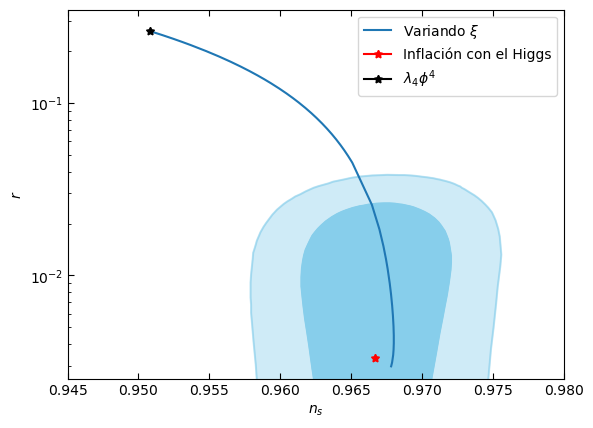

In [118]:
bck1s=np.loadtxt("bck1s.txt",float)
bck2s=np.loadtxt("bck2s.txt",float)
bck1s_n_s,bck1s_r=bck1s[:,0],bck1s[:,1]
bck2s_n_s,bck2s_r=bck2s[:,0],bck2s[:,1]

N=60
n_s_univ=1-2/N
r_univ=12/N/N

plt.plot(bck1s_n_s,bck1s_r, color="skyblue", alpha=1)
plt.fill_between(bck1s_n_s,bck1s_r, color="skyblue", alpha=1)
plt.plot(bck2s_n_s,bck2s_r, color="skyblue", alpha=0.5)
plt.fill_between(bck2s_n_s,bck2s_r, color="skyblue", alpha=0.4)
plt.yscale("log")
plt.xlim(0.945,0.98)
plt.ylim(0.0025,0.35)
plt.xlabel("$n_s$")
plt.ylabel("$r$")
plt.plot(n_s_values,r_values,label="Variando $\\xi$")
plt.plot(n_s_univ,r_univ,marker=(5, 1),c='r',label="Inflación con el Higgs")
plt.plot(1-24/(8*N+8),128/(8*N+8),marker=(5, 1),c='k',label="$\lambda_4 \phi^4$")
plt.tick_params(axis='y', which='both', direction='in', length=2)
plt.tick_params(axis='both', direction='in', length=4)
plt.tick_params(bottom=True,top=True)
plt.legend()
plt.savefig('atractor.pdf', bbox_inches='tight')
plt.show()